In [1]:
import random
import numpy as np
import itertools
from Bio import SeqIO
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

print('libraries loaded!')

libraries loaded!


In [2]:
# This function mutates num_mutations number of mutations to a diferent nucleotide in a given sequence

def mutate_dna(dna_string, num_mutations):
    dna_list = list(dna_string)
    dna_length = len(dna_list)
    num_mutations = int(num_mutations * dna_length)
    if num_mutations > dna_length:
        raise ValueError("Number of mutations cannot exceed the length of the DNA string.")

    mutation_indices = random.sample(range(dna_length), num_mutations)

    for index in mutation_indices:
        current_base = dna_list[index]
        valid_bases = ['A', 'U', 'C', 'G']
        if current_base not in valid_bases:
            continue
        else:
            valid_bases.remove(current_base) # Ensure the new base is different.
            new_base = random.choice(valid_bases)
            dna_list[index] = new_base

    return "".join(dna_list)  # Convert back to a string

In [3]:
f = 'SILVA_138.2_SSURef_NR99_tax_silva_filtered_strict_2.fasta'

In [4]:
from tqdm import tqdm
klen = 4
kmers = {}
total_seqs = 0

for h,i in tqdm(enumerate(SeqIO.parse(f,'fasta'))):
    id,d,s,L = str(i.id),str(i.description),str(i.seq).upper(),len(i.seq)
    total_seqs += 1
    for i in range(0,len(s)+1-klen*2):
        kmer = s[i:i+klen]
        next_mer = s[i+klen:i+klen*2]
        if kmer not in kmers: kmers[kmer] = defaultdict(int)
        kmers[kmer][next_mer] += 1
    #if h == 100000: break

print("Run finished!")

282395it [05:39, 832.89it/s]

Run finished!


In [56]:
bio_neighbor_mers = {}
n_marker = 0

for kmer,v in kmers.items():
    # print(kmer)
    total_nextmer_count = sum(v.values())
    for next_mer,counts in v.items():
        proportion = counts/total_nextmer_count
        if proportion >= 0.1:
            if kmer not in bio_neighbor_mers:
                bio_neighbor_mers[kmer] = set()
            bio_neighbor_mers[kmer].add(next_mer)
            n_marker += 1
            # print(kmer,next_mer,proportion)

print(f"k-mer filtering step complete! Found {n_marker} biomarkers!")

k-mer filtering step complete! Found 273 biomarkers!


In [7]:
print(len(bio_neighbor_mers))
print(bio_neighbor_mers)

26
{'AAUU': {'GACG'}, 'GUUC': {'CCGG'}, 'CGCU': {'AGUA'}, 'UGUU': {'GGGU'}, 'GUUA': {'AGUC'}, 'UUUA': {'AUUC'}, 'UUAG': {'AUAC'}, 'UACA': {'AUGG'}, 'ACAU': {'GCAA'}, 'UAGA': {'UACC'}, 'UGUC': {'GUCA'}, 'UCCU': {'ACGG'}, 'UCAA': {'AGGA'}, 'GUUU': {'AAUU'}, 'AUUA': {'GAUA'}, 'CCUA': {'CGGG'}, 'CGUC': {'AGCU'}, 'CGAG': {'CGCA'}, 'UCGC': {'UAGU'}, 'GCAC': {'AAGC'}, 'CUCC': {'UACG'}, 'CGUU': {'CCCG'}, 'UUCC': {'CGGG'}, 'GCGC': {'AACC'}, 'ACAG': {'GAUU'}, 'UCUC': {'AGUU'}}


In [17]:
def get_biomarker_stats(seq):
    biomarkers_present = {}
    mer_nextMer_present = 0
    
    for i in range(0,len(s)+1-klen*2):
        kmer = seq[i:i+klen]
        next_mer = seq[i+klen:i+klen*2]
        if kmer in bio_neighbor_mers:
            if next_mer in bio_neighbor_mers[kmer]:
                if kmer not in biomarkers_present:
                    biomarkers_present[kmer] = defaultdict(int)
                mer_nextMer_present += 1
                biomarkers_present[kmer][next_mer] += 1
    return biomarkers_present, mer_nextMer_present

In [52]:
real,mutated = [],[]

total = 0
for h,i in enumerate(SeqIO.parse(f,'fasta')):
    total = h
    id,d,s,L = str(i.id),str(i.description),str(i.seq).upper(),len(i.seq)
    mutated_seq = mutate_dna(s, 0.1)
    biomarker_stats_real,biomarker_stats_real_total = get_biomarker_stats(s)
    biomarker_stats_mutated,biomarker_stats_mutated_total = get_biomarker_stats(mutated_seq)
    real.append(biomarker_stats_real_total)
    mutated.append(biomarker_stats_mutated_total)
    # print(biomarker_stats_real_total,biomarker_stats_mutated_total)
    print(h,end='\r')
    #if h == 10000: break

/tmp/ipykernel_3623523/2336531353.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([real,mutated],labels = ["Real","Mutated"])


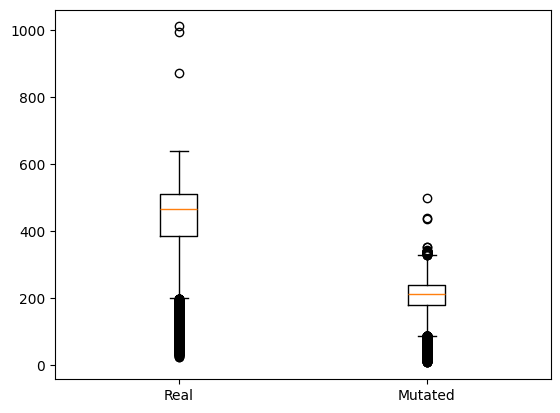

In [53]:
plt.boxplot([real,mutated],labels = ["Real","Mutated"])
plt.show()

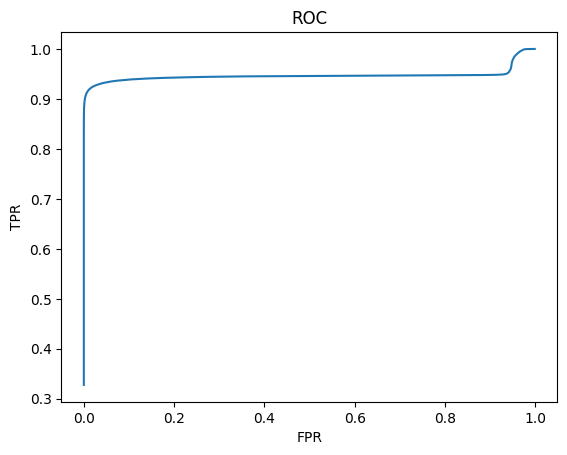

In [54]:
# thresholding ROC curve
max_thresh = np.max(mutated)
min_thresh = np.min(real)

TPRs = []
FPRs = []
for thresh in range(min_thresh,max_thresh):
    TPs = np.sum(np.array(real) >= thresh)
    FPs = np.sum(np.array(mutated) >= thresh)
    TPRs.append(TPs/total)
    FPRs.append(FPs/total)

# force standard ROC curve shape
"""
if 0.0 not in TPRs:
    TPRs = TPRs + [0.0]
    FPRs = FPRs + [0.0]

if 1.0 not in FPRs:
    FPRs = [1.0] + FPRs
    TPRs = [1.0] + TPRs"""

TPRs = np.array(TPRs)
FPRs = np.array(FPRs)

plt.plot(FPRs, TPRs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In [55]:
# find threshold with closest to equal FPR and TPR
score = np.abs(FPRs - (1-TPRs))
best = np.argmin(score)
print(min_thresh+best, 1-TPRs[best], FPRs[best])

268 0.06479245309744541 0.06269963242845103


In [314]:
TPRs[np.min(np.where(FPRs < 0.2))]

0.942

In [12]:
# automate coarse proportion threshold tuning
# score with balanced accuracy (BA) because it's easy to compute
best_ba = 0.0
best_thresh = 0.0
for prop_thresh in np.arange(0.1, 1.0, 0.1):
    bio_neighbor_mers = {}
    n_marker = 0

    for kmer,v in kmers.items():
        # print(kmer)
        total_nextmer_count = sum(v.values())
        for next_mer,counts in v.items():
            proportion = counts/total_nextmer_count
            if proportion >= prop_thresh:
                if kmer not in bio_neighbor_mers:
                    bio_neighbor_mers[kmer] = set()
                bio_neighbor_mers[kmer].add(next_mer)
                n_marker += 1
                # print(kmer,next_mer,proportion)

    if n_marker == 0: break

    real,mutated = [],[]

    total = 0
    for h,i in enumerate(SeqIO.parse(f,'fasta')):
        total = h
        id,d,s,L = str(i.id),str(i.description),str(i.seq).upper(),len(i.seq)
        mutated_seq = mutate_dna(s, 0.1)
        biomarker_stats_real,biomarker_stats_real_total = get_biomarker_stats(s)
        biomarker_stats_mutated,biomarker_stats_mutated_total = get_biomarker_stats(mutated_seq)
        real.append(biomarker_stats_real_total)
        mutated.append(biomarker_stats_mutated_total)
        # print(biomarker_stats_real_total,biomarker_stats_mutated_total)
        if h == 2000: break

    max_thresh = np.max(mutated)
    min_thresh = np.min(real)

    if max_thresh > min_thresh:
        TPRs = []
        FPRs = []
        for thresh in range(min_thresh,max_thresh):
            TPs = np.sum(np.array(real) >= thresh)
            FPs = np.sum(np.array(mutated) >= thresh)
            TPRs.append(TPs/total)
            FPRs.append(FPs/total)

        TPRs = np.array(TPRs)
        FPRs = np.array(FPRs)
        score = np.abs(FPRs - (1-TPRs))
        best = np.argmin(score)
        ba = (TPRs[best] + (1-FPRs[best])) / 2
        print('prop {:.2f}\tbest {:4}\tFNR {:.2f}\tFPR {:.2f}'.format(prop_thresh, min_thresh+best, 1-TPRs[best], FPRs[best]))
    else:
        print('prop {:.2f}\tperfect, range {} - {}'.format(prop_thresh, max_thresh, min_thresh))
        ba = 1.0

    if ba > best_ba:
        best_ba = ba
        best_thresh = prop_thresh

print('best prop and BA:', best_thresh, best_ba)

prop 0.10	best  130	FNR 0.03	FPR 0.02
prop 0.20	best   17	FNR 0.04	FPR 0.03
prop 0.30	best    1	FNR 0.09	FPR 0.37
best prop and BA: 0.1 0.97475
